In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
PATH_TO_PARQUET = Path(r"C:/Users/Ki/OneDrive - fer.hr/Documents/GitHub/ML-Projekt-Vicuna/btc_historical_price.parquet")

if not PATH_TO_PARQUET.exists():
    f"Datoteka nije pronađena: {PATH_TO_PARQUET}"

df = pd.read_parquet(PATH_TO_PARQUET)
print(df.shape)
df.head()

(50676, 7)


,Date,Open,High,Low,Close,Trades,Volume
0,2020-01-01 01:00:00,7189.43,7190.52,7170.15,7171.55,3688.0,2449.049
1,2020-01-01 02:00:00,7171.43,7225.00,7171.10,7210.24,6635.0,3865.038
2,2020-01-01 03:00:00,7210.38,7239.30,7206.46,7237.99,5120.0,3228.365
3,2020-01-01 04:00:00,7237.41,7239.74,7215.00,7221.65,4143.0,2513.307
4,2020-01-01 05:00:00,7221.80,7225.41,7211.22,7213.86,1966.0,1176.666


In [3]:
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

In [4]:
idx = df.index
full_range = pd.date_range(start=idx.min(), end=idx.max(), freq="H")
missing = full_range.difference(idx)
duplicated = idx[idx.duplicated()]

print("Početak:", idx.min())
print("Kraj:", idx.max())
print(f"Broj nedostajućih sati: {len(missing)}")
print(f"Broj duplikata: {len(duplicated)}")

Početak: 2020-01-01 01:00:00+00:00
Kraj: 2025-10-12 12:00:00+00:00
Broj nedostajućih sati: 0
Broj duplikata: 0


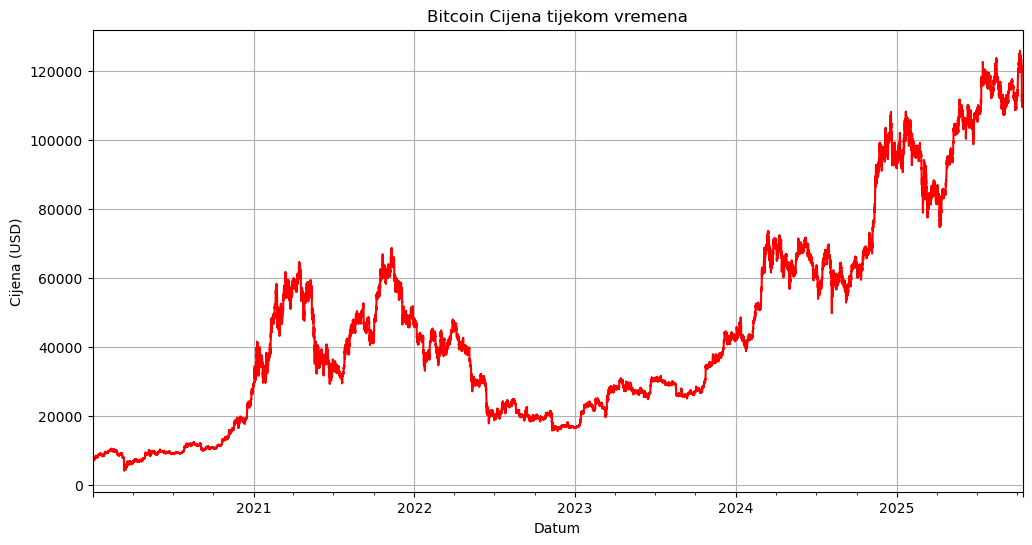

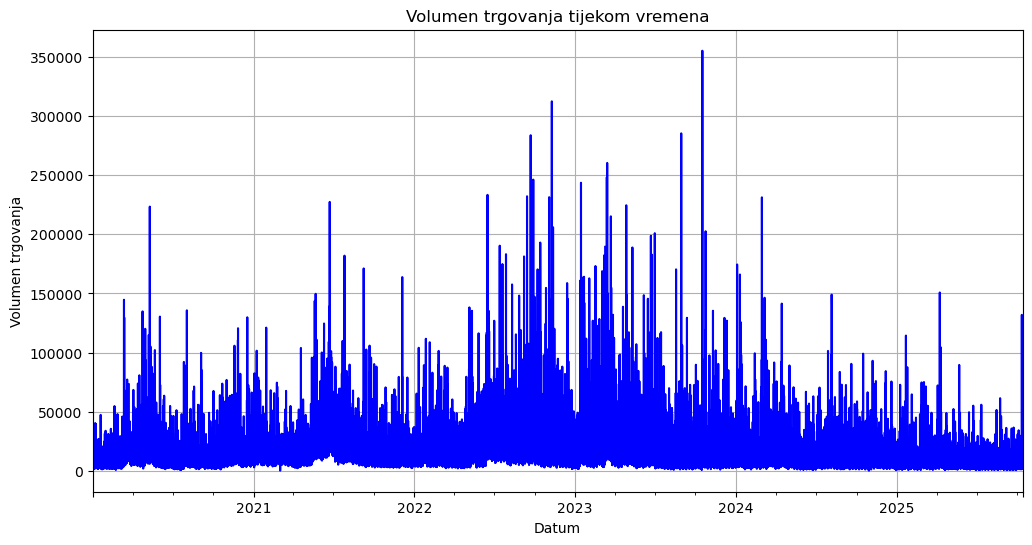

In [5]:
plt.figure(figsize=(12, 6))
df['Close'].plot(title='Bitcoin Cijena tijekom vremena', color = 'red')
plt.xlabel('Datum')
plt.ylabel('Cijena (USD)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
df['Volume'].plot(title='Volumen trgovanja tijekom vremena', color = 'blue')
plt.xlabel('Datum')
plt.ylabel('Volumen trgovanja')
plt.grid(True)
plt.show()



In [8]:
#Lagged returns
df["return_t_1"] = np.log(df["Close"] / df["Close"].shift(1))
df["return_t_5"] = np.log(df["Close"] / df["Close"].shift(5))
df["return_t_10"] = np.log(df["Close"] / df["Close"].shift(10))

In [18]:
#Volatilnost
df["volatility_5"] = df["return_t_1"].rolling(window=5*24).std()
df["volatility_10"] = df["return_t_1"].rolling(window=10*24).std()
df["volatility_20"] = df["return_t_1"].rolling(window=20*24).std()

In [10]:
#Moving averages
df["sma_5"] = df["Close"].rolling(window=5).mean()
df["sma_20"] = df["Close"].rolling(window=20).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()

In [11]:
#Volume indicators
df["volume_ratio_10"] = df["Volume"] / df["Volume"].rolling(window=10).mean()

In [12]:
#Price ratios
df["ratio_high_low"] = df["High"] / df["Low"]
df["ratio_close_open"] = df["Close"] / df["Open"]

In [ ]:
#Momentum indicators
df["momentum"] = df["Close"] - df["Close"].shift(5)

In [15]:
#Time-based features
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month

In [16]:
#Target variable: buduća stopa povrata
df["target_return_t+1"] = df["return_t_1"].shift(-1)

In [14]:
#Tehnički indikatori


# RSI (Relative Strength Index)
def compute_RSI(series, window=14):
    delta = series.diff(1)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["rsi_14"] = compute_RSI(df["Close"], window=14)

# MACD (Moving Average Convergence Divergence)
ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
df["macd"] = ema_12 - ema_26
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

# Bollinger Bands
window = 20
rolling_mean = df["Close"].rolling(window).mean()
rolling_std = df["Close"].rolling(window).std()
df["bb_high"] = rolling_mean + (2 * rolling_std)
df["bb_low"] = rolling_mean - (2 * rolling_std)

In [17]:
df = df.dropna().copy()

print("✅ Broj značajki:", len(df.columns))
df.head(10)

✅ Broj značajki: 29


,Open,High,Low,Close,Trades,Volume,return_1h,return_t_5,return_t_10,return_t_1,...,momentum_5,rsi_14,macd,macd_signal,bb_high,bb_low,hour,day_of_week,month,target_return_t+1
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 21:00:00+00:00,7226.56,7242.00,7223.09,7233.30,2239.0,1476.534,0.000961,0.000527,0.004996,0.000961,...,3.81,54.288105,12.820466,11.459936,7250.317587,7185.210413,21,2,1,-0.000496
2020-01-01 22:00:00+00:00,7233.32,7238.79,7225.00,7229.71,1838.0,1210.884,-0.000496,-0.001686,0.005139,-0.000496,...,-12.20,59.312867,12.392452,11.646439,7251.507475,7185.967525,22,2,1,-0.004811
2020-01-01 23:00:00+00:00,7229.71,7229.71,7183.26,7195.01,7244.0,4361.306,-0.004811,-0.005377,-0.003567,-0.004811,...,-38.79,49.926258,9.147798,11.146711,7249.678044,7183.498956,23,2,1,0.000356
2020-01-02 00:00:00+00:00,7195.00,7199.50,7174.00,7197.57,5400.0,3123.812,0.000356,-0.005528,-0.002494,0.000356,...,-39.90,54.440834,6.705659,10.258501,7249.436943,7181.332057,0,3,1,0.001488
2020-01-02 01:00:00+00:00,7197.57,7209.59,7182.19,7208.29,2722.0,1512.807,0.001488,-0.002502,-0.001180,0.001488,...,-18.06,53.790168,5.571040,9.321009,7249.301749,7180.910251,1,3,1,-0.002717
2020-01-02 02:00:00+00:00,7208.29,7208.30,7183.01,7188.73,3272.0,1872.396,-0.002717,-0.006181,-0.005654,-0.002717,...,-44.57,48.779577,3.058265,8.068460,7249.577128,7177.476872,2,3,1,-0.003089
2020-01-02 03:00:00+00:00,7188.64,7188.64,7155.00,7166.56,9696.0,5106.854,-0.003089,-0.008773,-0.010459,-0.003089,...,-63.15,32.495152,-0.713833,6.312001,7252.290631,7169.319369,3,3,1,-0.005495
2020-01-02 04:00:00+00:00,7166.92,7166.92,7121.00,7127.29,9568.0,4871.843,-0.005495,-0.009457,-0.014833,-0.005495,...,-67.72,26.627470,-6.793695,3.690862,7262.754161,7151.058839,4,3,1,0.001692
2020-01-02 05:00:00+00:00,7126.94,7159.30,7112.06,7139.36,8807.0,4720.779,0.001692,-0.008120,-0.013649,0.001692,...,-58.21,30.601202,-10.516850,0.849320,7267.499962,7140.725038,5,3,1,-0.000549


# 2. Modeliranje i evaluacija